In [1]:
import sys
#sys.path.append('/home/npopkov/dll24')
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
torch.set_float32_matmul_precision('medium')

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

import lightning as lt

import tables
tables.file._open_files.close_all()

class LatentDataset(Dataset):
    def __init__(self, h5_file):
        self.shape = np.array(h5_file[list(h5_file.keys())[0]]).shape
        self.data = self.createData(h5_file)
        self.min = self.data.min()
        self.max = self.data.max()
        self.std = self.data.std()
        self.mean = self.data.mean()
        self.transform('normalize')


    def createData(self, h5_file):
        data = []
        for key in h5_file.keys():
        
            sample = np.array(h5_file[key])

            data.append(np.array(sample))
        
        return torch.tensor(np.array(data)).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    def transform(self, type: str = 'normalize'):
        if type == 'standardize':
            self.data = (self.data - self.mean) / self.std
        elif type == 'normalize':
            self.data = (self.data - self.min) / (self.max - self.min)
        else:
            raise ValueError('Unknown transformation type')
        
    def inverse_transform(self, data):

        return data * (self.max - self.min) + self.min
    
    def unflatten(self, data):
        return data.reshape(self.shape)
    

hdf = h5py.File('256encodesamp.hdf5', 'r',)
dataset = LatentDataset(hdf)
hdf.close()



/home/npopkov/dll24/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model = Unet(
    dim = 64,
    channels = 1,
    dim_mults = (1, 2, 4),
    flash_attn = False,
)



model.load_state_dict(torch.load('model.pt'))

diffusion = GaussianDiffusion(
    model,
    image_size = 256,
    timesteps = 1000,
        # number of steps
)

In [ ]:
diffusion.to('cuda')
diffusion.device

device(type='cuda', index=0)

In [4]:
diffusion.eval()
generated = diffusion.sample(batch_size=6)
generated = dataset.inverse_transform(generated)

sampling loop time step: 100%|██████████| 1000/1000 [01:34<00:00, 10.62it/s]


In [5]:
generated.shape

torch.Size([6, 1, 256, 256])

In [6]:
import dac

dac_model_path = dac.utils.download(model_type='24kHz')
dac_model = dac.DAC.load(dac_model_path)

/home/npopkov/dll24/.conda/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [17]:
cut_generated = generated[:,:,:,:-1]
print(cut_generated.shape)
gen_z,_,_ = dac_model.quantizer.from_latents(cut_generated[2].cpu())
rebuild_generated = dac_model.decode(gen_z)


torch.Size([6, 1, 256, 255])


In [8]:
rebuild_generated.shape

torch.Size([1, 1, 81592])

In [18]:
from IPython.display import Audio

Audio(rebuild_generated.squeeze().detach().numpy(), rate=24000)


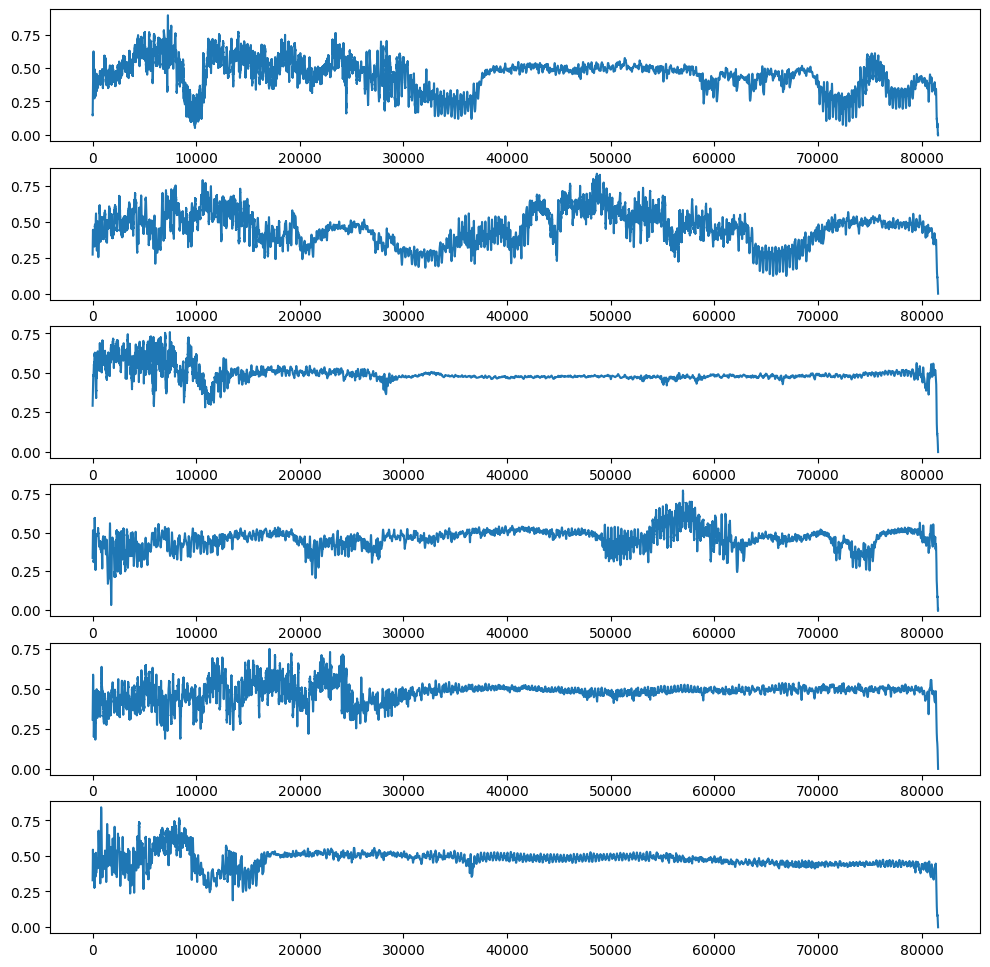

In [14]:
fig, ax = plt.subplots(6, 1, figsize=(12, 12))
for i in range(6):
    gen, _ ,_ = dac_model.quantizer.from_latents(cut_generated[i].cpu())
    x = dac_model.decode(gen)
    ax[i].plot(x.squeeze().detach().numpy())